In [1]:
from luxai_s2.env import LuxAI_S2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
env = LuxAI_S2() # create the environment object
obs, _ = env.reset(seed=41) # resets an environment with a seed

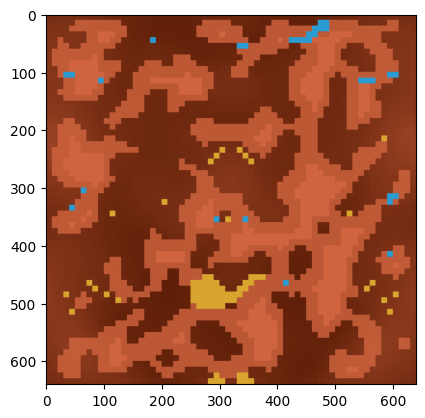

In [3]:
img = env.render("rgb_array", width=640, height=640)
plt.imshow(img)

In [4]:
from lux.kit import obs_to_game_state, GameState, EnvConfig
from luxai_s2.utils import animate
from lux.utils import direction_to, my_turn_to_place_factory

In [5]:
def animate(imgs, _return=True):
    # using cv2 to generate videos as moviepy doesn't work on kaggle notebooks
    import cv2
    import os
    import string
    import random
    video_name = ''.join(random.choice(string.ascii_letters) for i in range(18))+'.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width,height))

    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
    if _return:
        from IPython.display import Video
        return Video(video_name)
def interact(env, agents, steps):
    # reset our env
    obs, _ = env.reset()
    np.random.seed(0)
    imgs = []
    step = 0
    # Note that as the environment has two phases, we also keep track a value called 
    # `real_env_steps` in the environment state. The first phase ends once `real_env_steps` is 0 and used below

    # iterate until phase 1 ends
    while env.state.real_env_steps < 0:
        if step >= steps: break
        actions = {}
        for player in env.agents:
            o = obs[player]
            a = agents[player].early_setup(step, o)
            actions[player] = a
        step += 1
        obs, rewards, terminations, truncations, infos = env.step(actions)
        imgs += [env.render("rgb_array", width=640, height=640)]
#         print(termination)
        dones = {k: terminations[k] or truncations[k] for k in terminations}
    done = False
    while not done:
        if step >= steps: break
        actions = {}
        for player in env.agents:
            o = obs[player]
            a = agents[player].act(step, o)
            actions[player] = a
        step += 1
        obs, rewards, terminations, truncations, infos = env.step(actions)
        imgs += [env.render("rgb_array", width=640, height=640)]
        dones = {k: terminations[k] or truncations[k] for k in terminations}
        done = dones["player_0"] and dones["player_1"]
    return animate(imgs)

In [6]:
# recreate our agents and run
import sys

from importlib import reload
import agent
reload(agent)
Agent = agent.Agent

agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, 30)

/workspaces/LuX-AI-Season-2/.venv/lib/python3.10/site-packages/pygame/sysfont.py:223: UserWarning: 'fc-list' is missing, system fonts cannot be loaded on your platform
  warnings.warn(
OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


In [7]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import colorsys
    c = np.array(color) / 255.
    c = colorsys.rgb_to_hls(*c[::-1])
    return np.int16(np.array(colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])[::-1]) * 255)

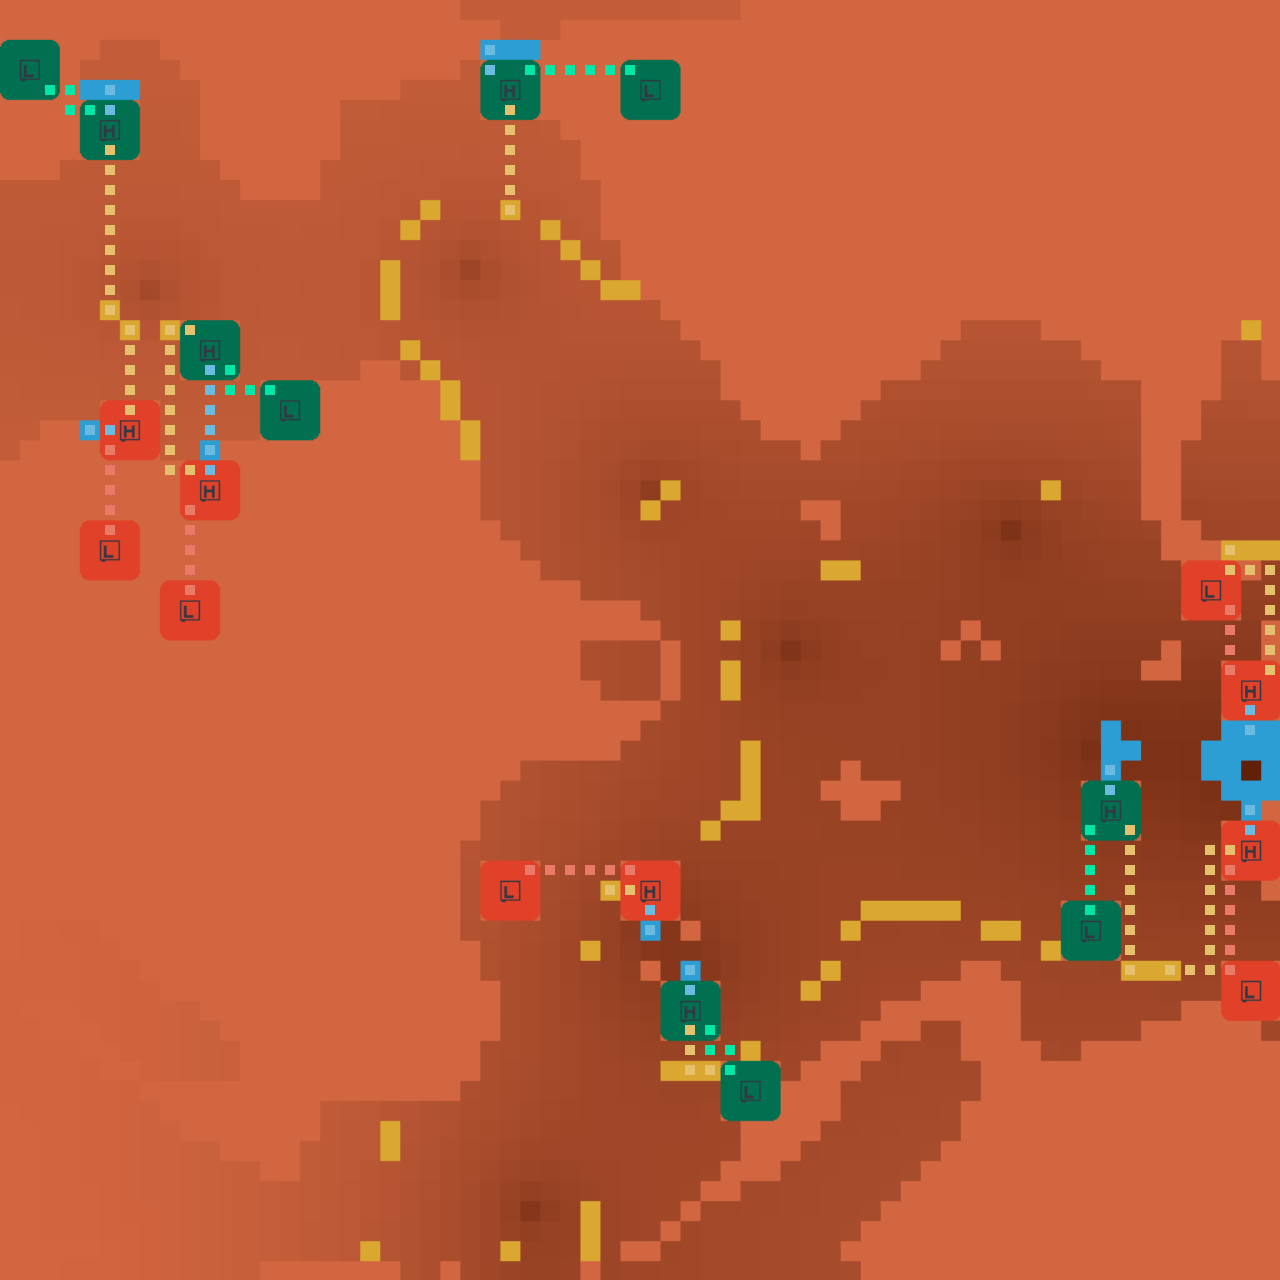

In [8]:
import agent
reload(agent)
agents = {player: agent.Agent(player, env.state.env_cfg) for player in env.agents}
obs, _ = env.reset(549339702)
np.random.seed(0)
imgs = []
step = 0

# Note that as the environment has two phases, we also keep track a value called 
# `real_env_steps` in the environment state. The first phase ends once `real_env_steps` is 0 and used below
team_color = dict(player_0=[224, 65, 40], player_1=[0, 112, 81])
ice_color = [44, 158, 211]
ore_color = [218, 167, 48]
TILE_WIDTH = 20
RECT = slice(TILE_WIDTH//2 - TILE_WIDTH//4, TILE_WIDTH//2 + TILE_WIDTH//4)
# iterate until phase 1 ends
while env.state.real_env_steps < 0:
    actions = {}
    for player in env.agents:
        o = obs[player]
        a = agents[player].early_setup(step, o)
        actions[player] = a
    step += 1
    obs, rewards, terminations, truncations, infos = env.step(actions)
    imgs += [env.render("rgb_array", width=env.env_cfg.map_size * TILE_WIDTH, height=env.env_cfg.map_size * TILE_WIDTH)]
#         print(termination)
    dones = {k: terminations[k] or truncations[k] for k in terminations}
done = False
while not done:
    if env.state.real_env_steps > 0: break
    actions = {}
    for player in env.agents:
        o = obs[player]
        a = agents[player].act(step, o)
        actions[player] = a
    step += 1
    obs, rewards, terminations, truncations, infos = env.step(actions)
    imgs += [env.render("rgb_array", width=env.env_cfg.map_size * TILE_WIDTH, height=env.env_cfg.map_size * TILE_WIDTH)]
    dones = {k: terminations[k] or truncations[k] for k in terminations}
    done = dones["player_0"] and dones["player_1"]
img = imgs[-1]
for player in env.agents:
    ag = agents[player]
    game_state = obs_to_game_state(step, env.state.env_cfg, obs[player])
    factories = game_state.factories[player]
    for factory_id, factory_state in ag.factory_states.items():
        factory = factories[factory_id]
        if factory_state.plans is None:
            continue
        for plan_name, plan in factory_state.plans.items():
            if plan_name == "factory_to_factory":
                color = team_color[player]
            elif plan_name == "ice":
                color = ice_color
            elif plan_name == "ore":
                color = ore_color
            else:
                raise NotImplementedError()
            color = lighten_color(color, 0.7)
            for pos in plan.route.path:
                img[pos[1] * TILE_WIDTH : (pos[1]+1) * TILE_WIDTH, pos[0] * TILE_WIDTH : (pos[0]+1) * TILE_WIDTH][RECT, RECT] = color
plt.imsave("plan.png", img)
from IPython.display import Image
Image("plan.png")